In [1]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import FunctionModule as fm #the FunctionModule.py is the python file of all of the required functions for this assignment
#It was also uploaded for this assignment, and must be in the same directory as the code below and the .npz files

## Radial Velocity Model

Getting the data from the .npz file:


In [2]:
a = np.load('JSAstroLab2023_rv_data_20332692.npz')
#loads the data from the .npz file

spectra_keys, time_keys = fm.keylistr(a) #finds the keys corresponding to each spectrum and timestamp
#note the keylistr() function works by the fact that all odd keys are for timestamps and all even keys are for spectra

spectra = np.array([a[i] for i in spectra_keys])
times = np.array([a[i] for i in time_keys]) 
#above the the keys found via the keylistr() function are used to take the data for each spectrum and timestamp 
#and put them into an array of spectra and an array of times

wavelengths, velocities, template = a['wavelength'], a['velocity'], a['spec_template']
#these 3 keys are for the wavelength of each spectra, the velocities and the template spectrum. 

Finding the radial velocities of each spectrum, this may take a minute to run

In [3]:
radial_vs, stdevs, errors = [], [], []
for i in spectra:
    #not using list comprehension to only run velocity_findr once
    rv, std, err = fm.velocity_findr(i)
    radial_vs.append(rv)
    stdevs.append(std)
    errors.append(err)

Fitting a Sine curve to the data

In [4]:
param0 = [35, 5.46, np.pi/2, -3930] #initial parameters from inspecting the graph of velocity vs time

popt, pcov = opt.curve_fit(fm.sine_curve_fit, times, radial_vs, p0=param0)#, bounds=( (25,3,-np.inf,-3950), (35,6,np.inf,-3900) ))
#although fmin was used initially, curve_fit allows the errors in each parameter to be found
final_params = popt

err_fit = np.sqrt(np.diag(pcov)) #diagonalising the covarient matrix to find the errors

In [5]:
param_names = ['K_*','B','C','Systemic Velocity']
for i in range(len(final_params)):
    print(param_names[i], ':', final_params[i], '±', err_fit[i])

print('Initial Chi Squared value')
print(fm.chi2(param0,fm.sine,times, radial_vs))
print('Final Chi Squared value')
print(fm.chi2(final_params,fm.sine,times, radial_vs))

K_* : 31.682234441908935 ± 277349.5784986044
B : 5.459999891155505 ± 0.03568926819523005
C : 2.158568615470017 ± 88575.28766316785
Systemic Velocity : -3937.310686326008 ± 0.6941336197432755
Initial Chi Squared value
5426.404767353397
Final Chi Squared value
658.8402452412304


Plotting the data and the fit

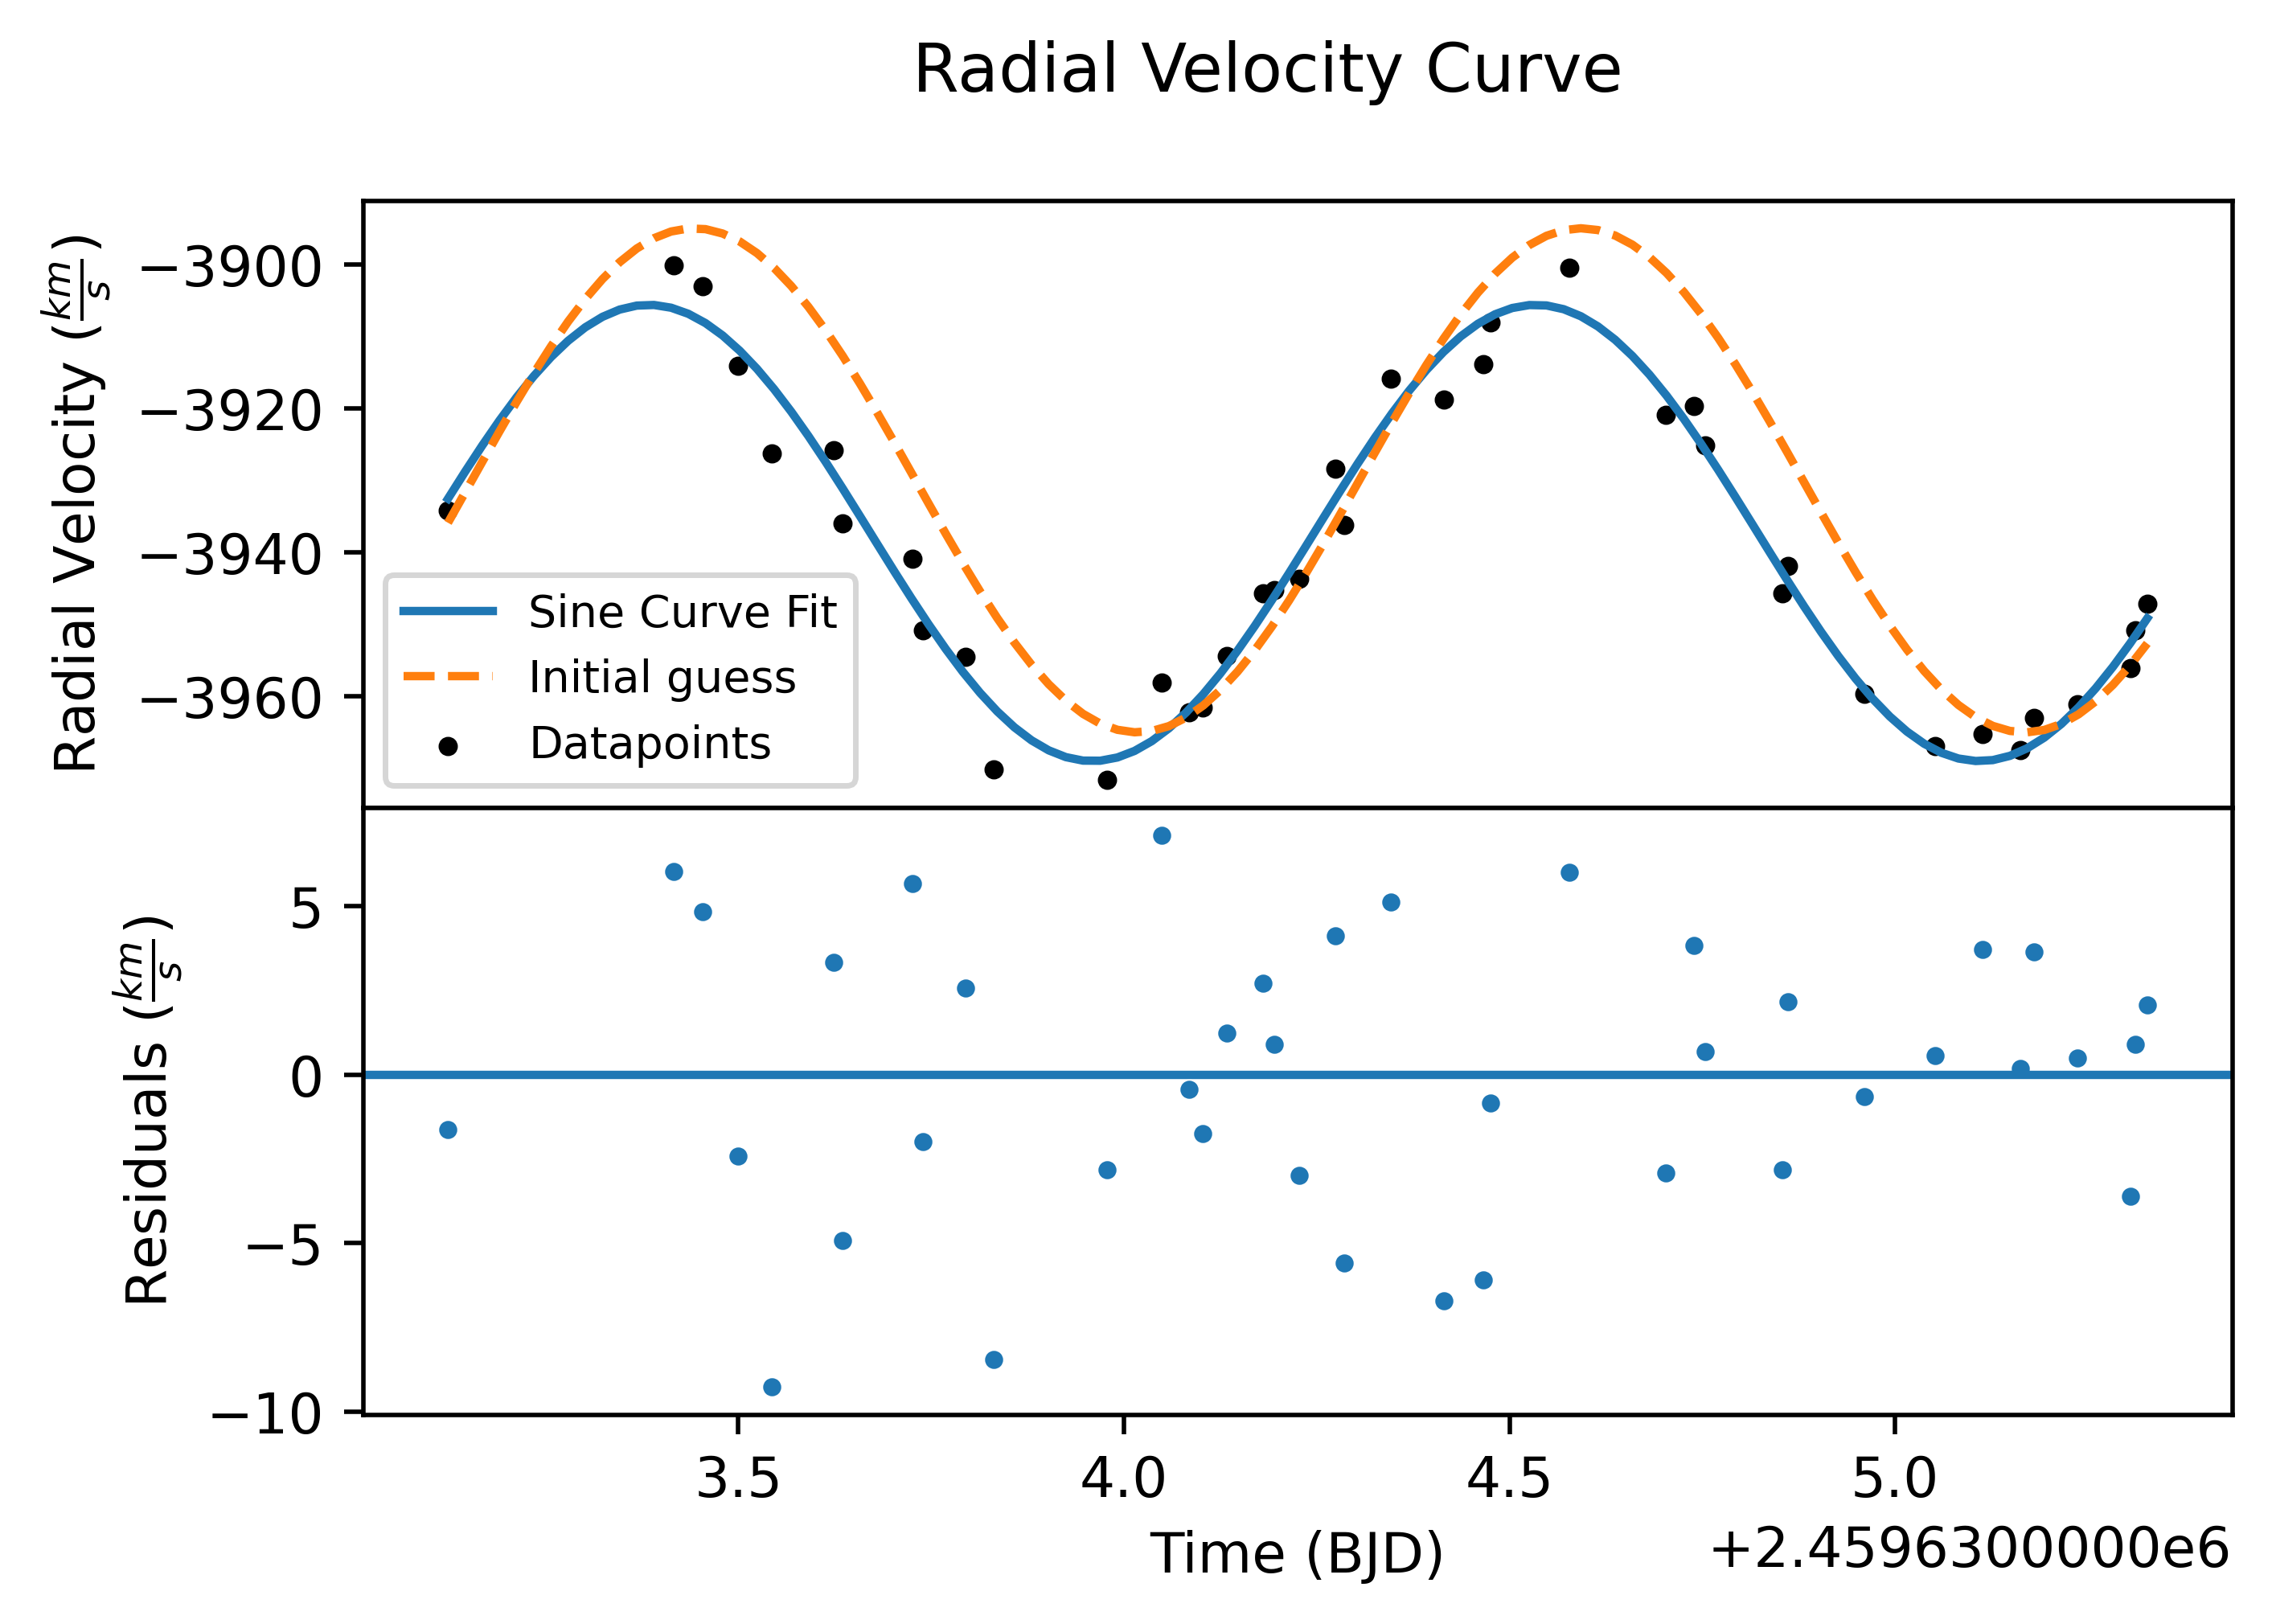

In [6]:
sintimes =  np.linspace(np.min(times),np.max(times),100) #creating a new time array for plotting the sine curve nicely
initialys = np.array([fm.sine(param0,i) for i in sintimes]) #sine curve using the initial parameters
ys_sin = np.array([fm.sine(final_params,i) for i in sintimes]) #sine curve using the final parameters


fig = plt.figure(dpi=500)
gs = fig.add_gridspec(2, hspace=0,height_ratios=[1, 1]) #gets 2 subplots with not space in between them horizontally
axs = gs.subplots(sharex=True) #sharing the x axis
fig.suptitle('Radial Velocity Curve')
axs[0].plot(sintimes,ys_sin,label= 'Sine Curve Fit')
axs[0].plot(sintimes, initialys,'--',label='Initial guess')
axs[0].scatter(times,radial_vs,c='black',s=6,label='Datapoints')

axs[0].legend(loc=3, prop={'size': 8})
axs[0].set_ylabel(r'Radial Velocity ($\frac{km}{s}$)')

axs[1].scatter(times, fm.residuals(final_params, fm.sine, times, radial_vs),s=5,label='Residuals') #plots residuals using residual function in module
axs[1].axhline(0)
axs[1].set_ylabel(r'Residuals ($\frac{km}{s}$)')
axs[1].set_xlabel('Time (BJD)')

for ax in axs:
    ax.label_outer() #only leave outermost axes in the plot
    
# plt.savefig('radial_vel_curve.png',bbox_inches='tight')
#commented out to prevent it from saving onto your computer

To show the correlation of 1 spectrum and fit a gaussian to it 

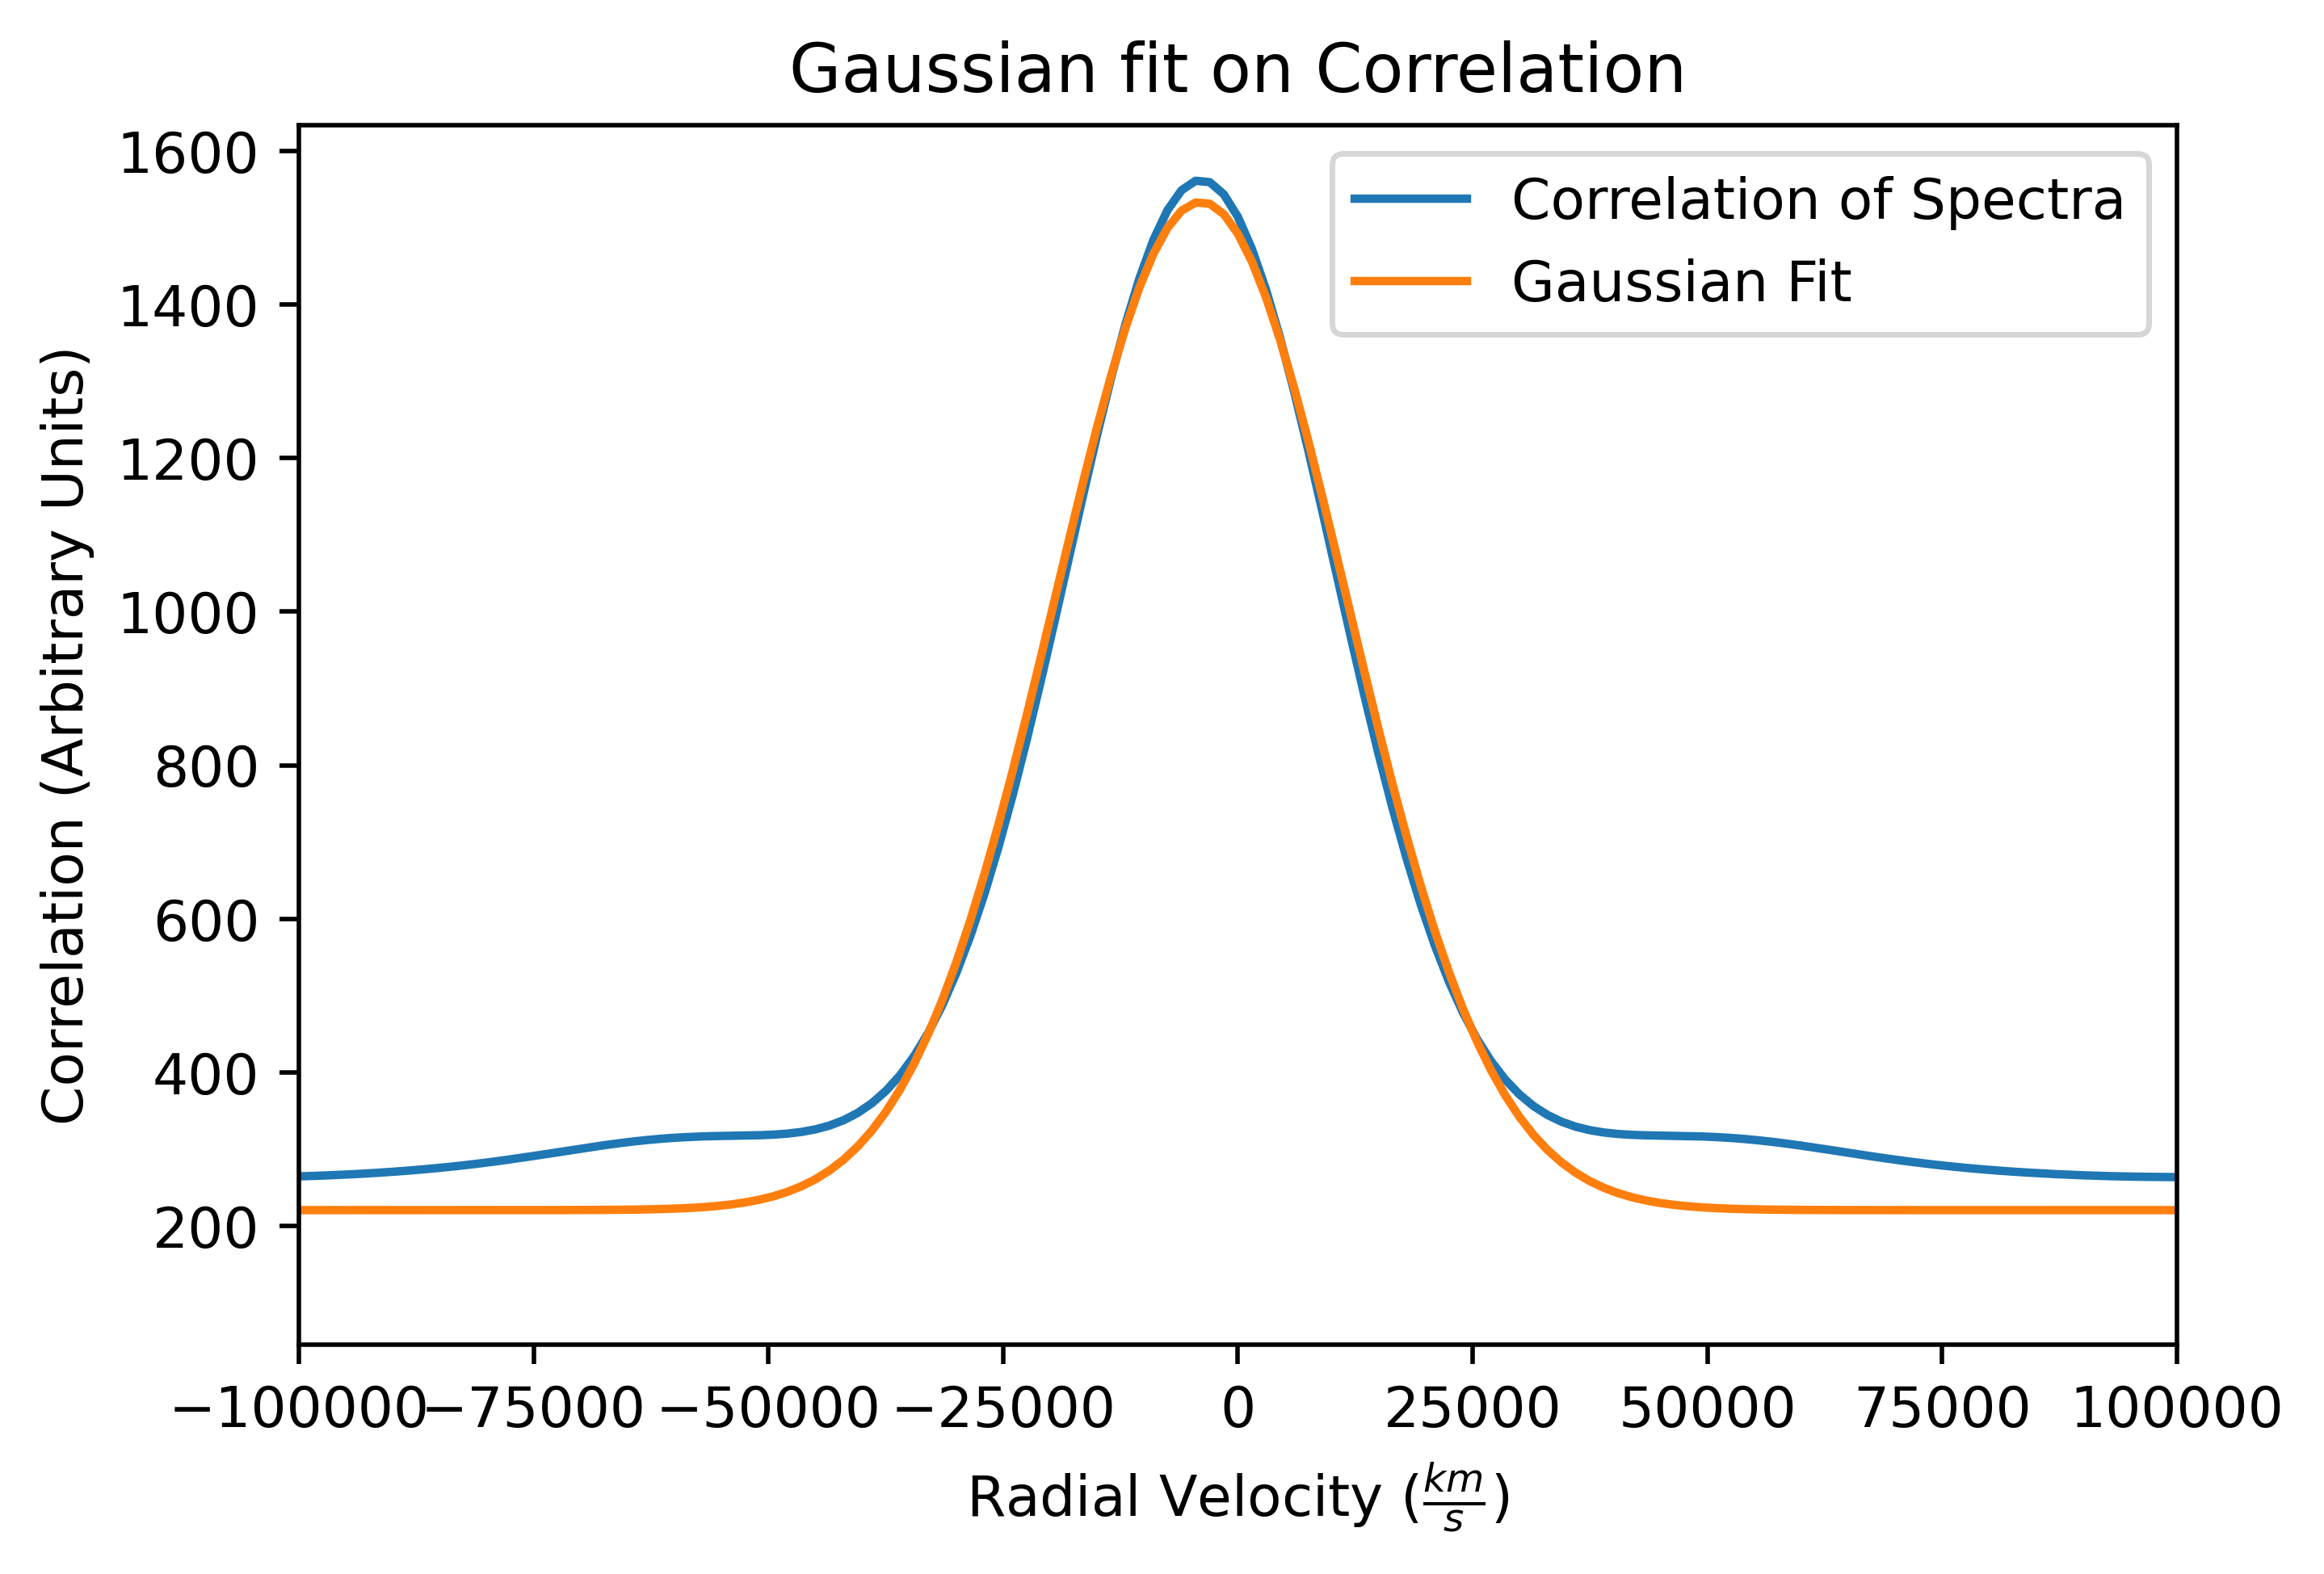

In [7]:
showcase = fm.correlate(spectra[20]) #taking spectra number 20 as an example
popt, pcov = opt.curve_fit(fm.gaussian, velocities, showcase) #fitting a gaussian to the correlation
A,B,C,D = popt #formatting for the gaussian function in fm

plt.figure(dpi=500)
plt.plot(velocities,showcase,label='Correlation of Spectra')
plt.plot(velocities, fm.gaussian(velocities, A,B,C,D), label='Gaussian Fit')
plt.title('Gaussian fit on Correlation')
plt.xlim(-10**5,10**5)
plt.ylabel('Correlation (Arbitrary Units)')
plt.xlabel(r'Radial Velocity ($\frac{km}{s}$)')
plt.legend(loc='upper right')

# plt.savefig('Correlation_showcase.png',bbox_inches='tight') 
#commented out to prevent it from saving onto your computer

In [8]:
print('Radial Velocity is', B, '±', C) #this C value can is too large to be used
#as such the error in each value can be taken as the error in the fit parameter (Error 2 below)
print('Radial Velocity, Error 1, Error 2:')
print(fm.velocity_findr(spectra[20]))
#however this error is also too large, the error from the correlations is too large to be useful 
#eg the radial velocity curve has amplitude of ~30, error of ±180 is too large.

Radial Velocity is -3936.1774648360206 ± 15546.467991427262
Radial Velocity, Error 1, Error 2:
(-3936.1774648360206, 15546.467991427262, 179.673192489996)


## Transit Model 

Getting the data from the .npz file

In [16]:
b = np.load('JSAstroLab2023_transit_data_20332692.npz')

t_keys = list(b.keys())
#keys are time flux and period
times = b['time']
fluxes = b['flux']
P = b['P']

Fitting the transit function to the data

In [85]:
param0 =[2.64435573e+06  , 10, 0.155, 1.574+0.001,1.001]# initial guess parameters 


popt,pcov = opt.curve_fit(fm.flux_findr_curvefit, times, fluxes,p0=param0,bounds=(0,np.inf))

Plotting the Transit curve and the fit

Text(0.5, 0, 'Time (BJD)')

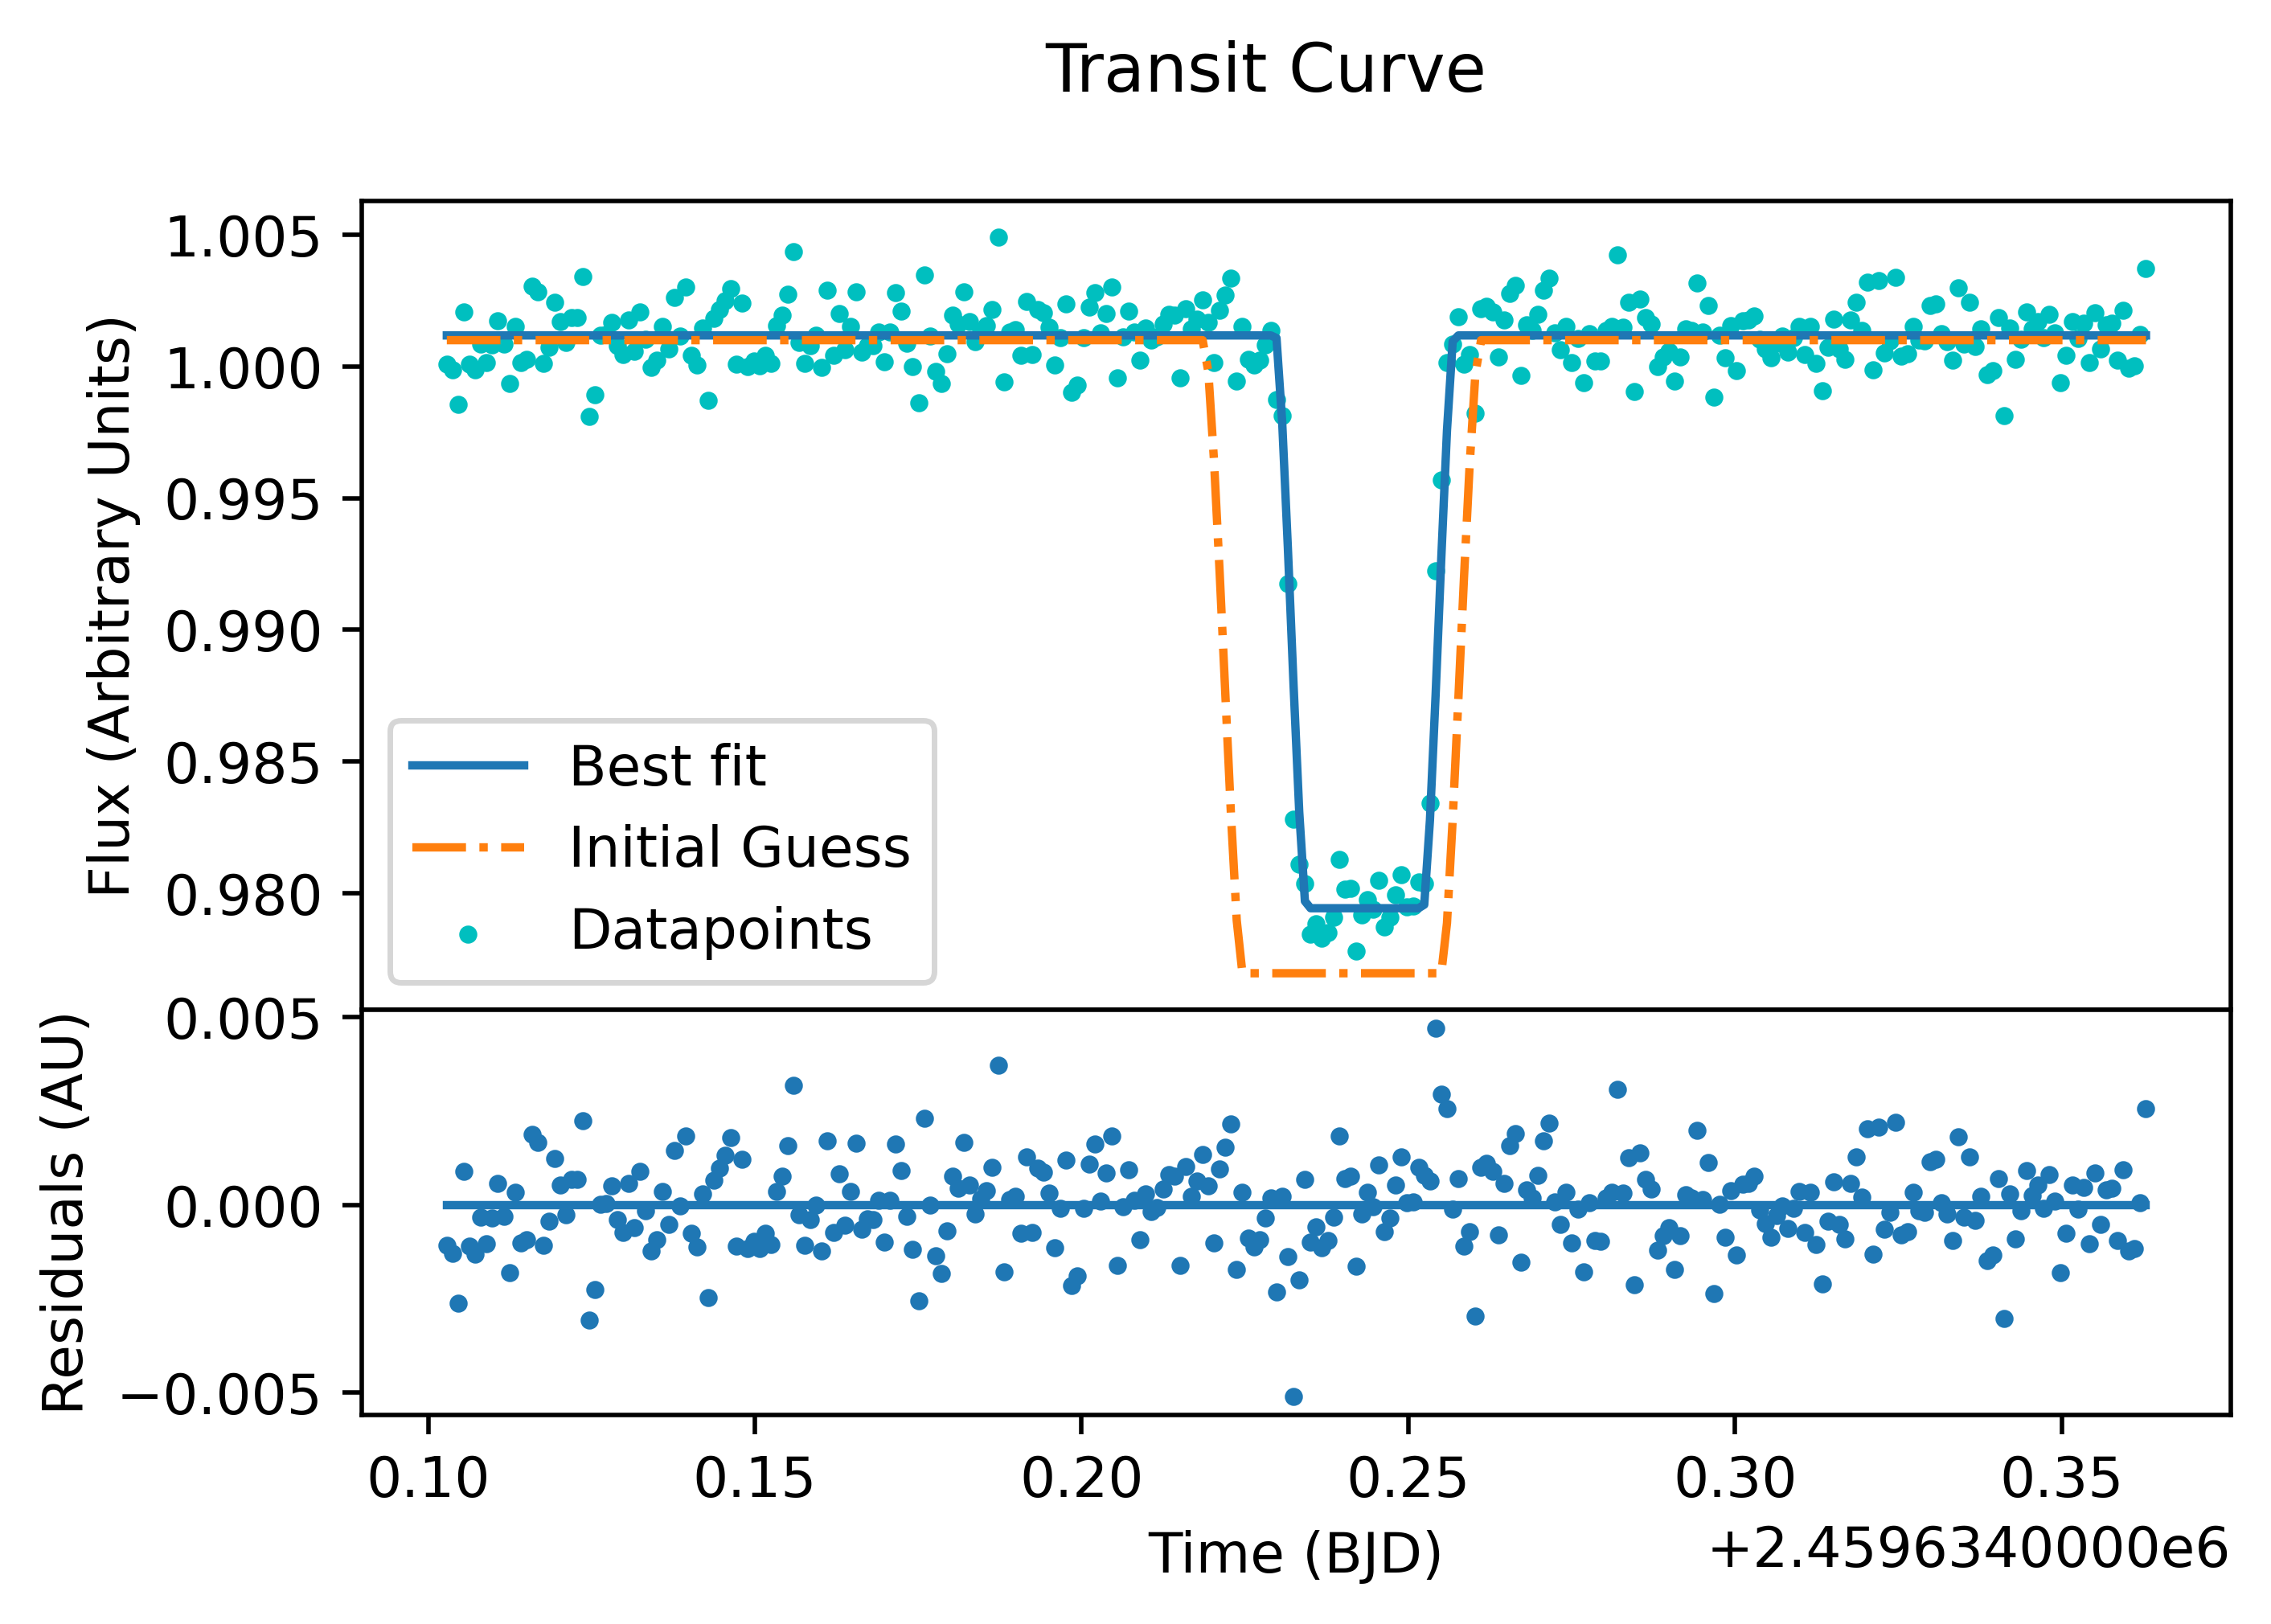

In [86]:
initial_guess = [fm.flux_plottr(param0,time) for time in times] #transit curve with initial parameters
curve_fit_ys = [fm.flux_plottr(popt,time) for time in times] #transit curve using final parameters

fig = plt.figure(dpi=500)
gs = fig.add_gridspec(2, hspace=0,height_ratios=[2, 1]) #gets 2 subplots with not space in between them horizontally, with different heights
axs = gs.subplots(sharex=True) #sharing the x axis
fig.suptitle('Transit Curve')
axs[0].plot(times,curve_fit_ys,label='Best fit')
axs[0].plot(times, initial_guess,ls='-.',label='Initial Guess')
axs[0].scatter(times,fluxes,s=5,c='c',label='Datapoints')
axs[0].set_ylabel('Flux (Arbitrary Units)')
axs[0].legend()

axs[1].scatter(times, fm.residuals(popt, fm.flux_findr, times, fluxes),s=5)
axs[1].plot(times,np.zeros(times.size))
axs[1].set_ylabel('Residuals (AU)')
axs[1].set_xlabel('Time (BJD)')

# plt.savefig('Transit_curve.png',bbox_inches='tight') 
#commented out to prevent it from saving onto your computer

Printing out the final parameters and their error

In [87]:
e_fit = np.sqrt(np.diag(pcov)) #finding the error in the parameters

names_params = ['T_0', 'a_over_R', 'rho', 'i', 'f_oot']
print( names_params[0]+' : '+ str(popt[0]/2.45963e6) + ' ± ' + str(e_fit[0]/2.459634e6))
for l in range(1,5):
    print( names_params[l]+' : '+ str(popt[l]) + ' ± ' + str(e_fit[l])) 

T_0 : 1.0751030575724203 ± 1.931122228633039e-10
a_over_R : 13.697958859031932 ± 0.5169908815153449
rho : 0.14742360840683136 ± 0.001361320880483644
i : 1.6086701619402182 ± 0.005283816305780262
f_oot : 1.0011791829857866 ± 7.912881815413277e-05


calculating values

0.0034124471403517453

from this can find:
mass, radius, density, semi major axis,inclination
can also find surface gravity - john winn